In [1]:
# -------------------- Instalar y configurar Spark en Colab --------------------
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar -xzf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
# Configurar entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [3]:
import findspark
findspark.init()

In [4]:
# -------------------- Importar librerías --------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
# -------------------- Inicializar Spark --------------------
spark = SparkSession.builder \
    .appName("S&P 500 Linear Regression with Spark") \
    .getOrCreate()

In [6]:
# -------------------- Cargar archivos desde tu computadora --------------------
from google.colab import files
uploaded = files.upload()

Saving gspc_daily_price.csv to gspc_daily_price (1).csv
Saving gspc_monthly_price.csv to gspc_monthly_price (1).csv
Saving news_sentiment_data.csv to news_sentiment_data (1).csv
Saving vix_daily_price.csv to vix_daily_price (1).csv


In [7]:
# -------------------- Leer CSVs con Spark --------------------
gspc_df = spark.read.csv("gspc_daily_price.csv", header=True, inferSchema=True)
vix_df = spark.read.csv("vix_daily_price.csv", header=True, inferSchema=True)
sentiment_df = spark.read.csv("news_sentiment_data.csv", header=True, inferSchema=True)

In [8]:
# -------------------- Convertir fechas y limpiar --------------------
gspc_df = gspc_df.withColumn("Date", to_date(col("Date")))
vix_df = vix_df.withColumn("Date", to_date(col("Date")))
sentiment_df = sentiment_df.withColumn("date", to_date(col("date"))).withColumnRenamed("date", "Date")


In [9]:
# -------------------- CREAR VISTAS TEMPORALES --------------------
gspc_df.createOrReplaceTempView("gspc")
vix_df.createOrReplaceTempView("vix")
sentiment_df.createOrReplaceTempView("sentiment")

In [10]:
query = """
SELECT g.Date,
       g.Open AS Open_sp500,
       g.High AS High_sp500,
       g.Low AS Low_sp500,
       g.Close AS Close_sp500,
       g.Volume,
       v.Close AS Close_vix,
       s.`News Sentiment`
FROM gspc g
LEFT JOIN vix v ON g.Date = v.Date
LEFT JOIN sentiment s ON g.Date = s.Date
"""

In [11]:
# Ejecutar consulta con query completo y bien definido
merged_df = spark.sql(query)

In [12]:
# -------------------- CONVERTIR A PANDAS --------------------
df = merged_df.toPandas()
df.fillna(0, inplace=True)

<ipython-input-12-8e4a41d90b23>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


In [13]:
# -------------------- CALCULAR RSI --------------------
def calculate_rsi(data, window=14):
    delta = data['Close_sp500'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df)
df.fillna(0, inplace=True)

In [14]:
# -------------------- PREPARAR PARA REGRESIÓN LINEAL --------------------
df['Next_Day_Close'] = df['Close_sp500'].shift(-1)
df = df.dropna()

features = ['Open_sp500', 'High_sp500', 'Low_sp500', 'Close_sp500', 'Volume', 'RSI_14', 'Close_vix', 'News Sentiment']
X = df[features]
y = df['Next_Day_Close']

In [15]:
# -------------------- DIVIDIR Y ENTRENAR MODELO --------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [16]:
# -------------------- MÉTRICAS --------------------
print("Model Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

Model Evaluation:
MAE: 13.08
MSE: 253.15
R²: 0.9973


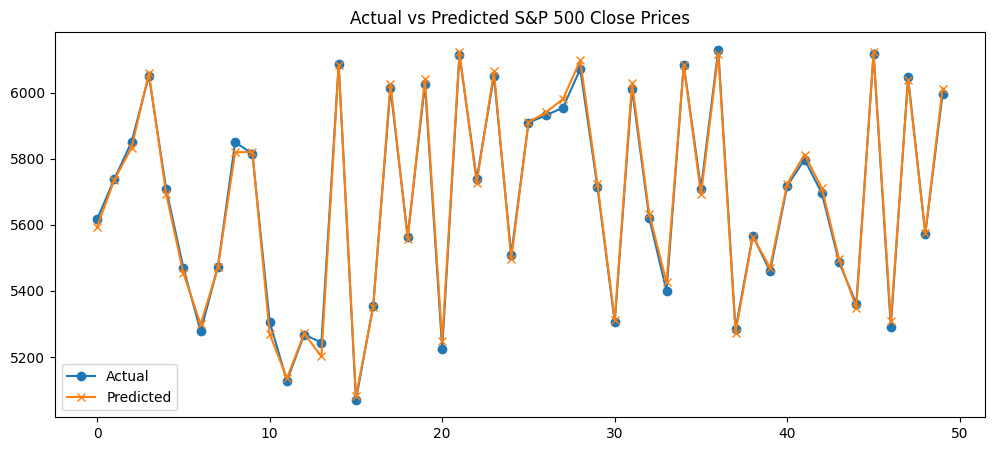

In [17]:
# -------------------- VISUALIZAR PREDICCIONES --------------------
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted S&P 500 Close Prices")
plt.show()

In [18]:
# -------------------- PREDECIR PRECIO DE MAÑANA --------------------
latest_data = df[features].iloc[-1:].copy()
tomorrow_pred = model.predict(latest_data)[0]
today_close = df['Close_sp500'].iloc[-1]
change = tomorrow_pred - today_close
percent_change = (change / today_close) * 100

print(f"Predicted Close Price for Tomorrow: ${tomorrow_pred:.2f}")
print(f"Change: {change:.2f} points ({percent_change:.2f}%)")

Predicted Close Price for Tomorrow: $5135.99
Change: -42.52 points (-0.82%)
